# Systematic Trend Following Showcase

This notebook highlights the full research workflow provided by the `tf-trend` starter project. It covers configuration loading, data quality checks, baseline backtesting, attribution, robustness studies, and research utilities that mirror a production systematic trend-following process.

## Notebook Roadmap

1. Configure the environment and load market data.
2. Run validation checks on the synthetic futures universe.
3. Execute the baseline backtest and inspect core performance.
4. Explore exposures, PnL attribution, and trading diagnostics.
5. Perform parameter sweeps for robustness.
6. Run walk-forward validation to separate training and test periods.
7. Quantify uncertainty with Monte-Carlo confidence intervals.
8. Use sensitivity utilities to profile parameter response surfaces.
9. Summarise generated artefacts and next steps.


In [ ]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")

REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "tf_trend_repo" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

RESULTS_DIR = REPO_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

REPO_ROOT

## 1. Load configuration, universe metadata, and prices

The :mod:`tf.api` helpers prepare a backtester instance alongside a context object that captures the resolved configuration, generated price history, and contract metadata. The starter configuration uses synthetic data when Yahoo! Finance history is unavailable, ensuring the example runs offline.

In [2]:
from tf import api
from tf.data.metadata import UniverseDefinition

CONFIG_PATH = REPO_ROOT / "configs" / "base.yaml"

backtester, context = api.prepare_backtester(CONFIG_PATH)
prices = context.prices.copy()
universe = UniverseDefinition.from_payload(context.universe)

universe.as_dataframe()

,sector,point_value,currency,contract_step,data_source,data_symbol,description
symbol,,,,,,,
ES,Equities,50.0,USD,1.0,yahoo,ES=F,
NQ,Equities,20.0,USD,1.0,yahoo,NQ=F,
ZN,Rates,1000.0,USD,1.0,yahoo,ZN=F,
ZB,Rates,1000.0,USD,1.0,yahoo,ZB=F,
CL,Commodities,1000.0,USD,1.0,yahoo,CL=F,
GC,Commodities,100.0,USD,1.0,yahoo,GC=F,
6E,FX,125000.0,USD,1.0,yahoo,6E=F,
6J,FX,125000.0,USD,1.0,yahoo,6J=F,


### Inspect the resolved price history

The scaffold backfills missing quotes, forward-fills short gaps, and restricts the sample to the configured backtest window. The tail of the dataframe shows the synthetic daily settlements used in this notebook.

In [3]:
prices.tail()

,ES,NQ,ZN,ZB,CL,GC,6E,6J
2020-12-25,67.371064,238.508319,446.212006,76.374897,126.948803,481.844922,1009.387078,147.205099
2020-12-28,67.729173,239.874385,457.762710,76.697546,125.286547,476.682429,1016.721402,147.880964
2020-12-29,68.786681,241.854145,449.391169,76.929543,125.778332,478.778116,1016.970532,151.772443
2020-12-30,68.844892,236.805279,447.353690,77.040401,126.909060,481.710105,1015.551599,153.167101
2020-12-31,69.253830,240.119503,441.570550,79.218412,126.448325,479.652911,1009.154464,153.099063


## 2. Run data validation checks

Before allocating risk, the data layer can flag duplicated timestamps, excessive gaps, and extreme daily moves. These helpers are lightweight enough to run inside notebooks during exploratory work.

In [4]:
from tf.data.validators import detect_limit_moves, detect_trading_suspensions, validate_price_data

validate_price_data(prices, min_price=0.0, max_consecutive_missing=5)

suspensions = detect_trading_suspensions(prices, min_gap=2)
limit_candidates = detect_limit_moves(prices, threshold=0.08)

suspension_counts = {symbol: len(spans) for symbol, spans in suspensions.items()}
print("Suspension counts by symbol:", suspension_counts or "None detected")

if limit_candidates.empty:
    print("No potential limit moves flagged at the 8% threshold.")
else:
    display(limit_candidates.tail())

Suspension counts by symbol: None detected
No potential limit moves flagged at the 8% threshold.


### Visualise the continuous futures curves

The synthetic dataset approximates diversified trend-following exposures across equities, rates, FX, and commodities. Visual inspection confirms the time-series look reasonable before running the engine.

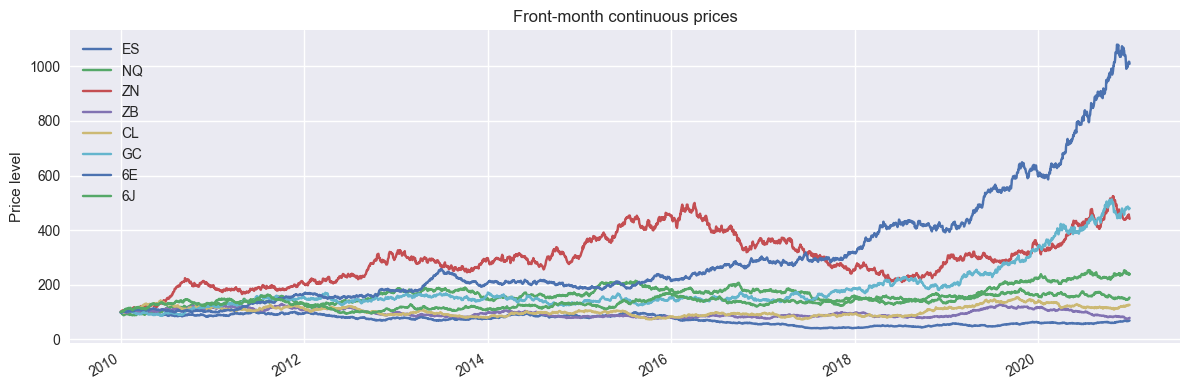

In [5]:
ax = prices.plot(figsize=(12, 4), title="Front-month continuous prices")
ax.set_ylabel("Price level")
plt.tight_layout()

## 3. Execute the baseline backtest

The daily event-loop engine orchestrates signal generation, risk targeting, execution, and rolling. Results include NAV, positions, trades, and ledger-level accounting.

In [6]:
from tf.eval.metrics import compute_rolling_metrics, performance_summary

result = backtester.run(check_reproducibility=True)
summary = performance_summary(result.nav, pnl=result.pnl, trades=result.trades)

pd.Series(summary, name="Baseline run")

CAGR            -0.004327
Volatility       0.013056
Sharpe          -0.325598
Sortino         -0.313431
Max Drawdown    -0.111264
Calmar          -0.038889
Skew            -0.082064
Kurtosis         0.429291
Turnover        30.959539
Hit Rate         0.482049
Name: Baseline run, dtype: float64

### Equity curve, drawdowns, and rolling diagnostics

Key time-series views make it easy to diagnose regime behaviour and volatility regimes directly from the raw artefacts returned by the engine.

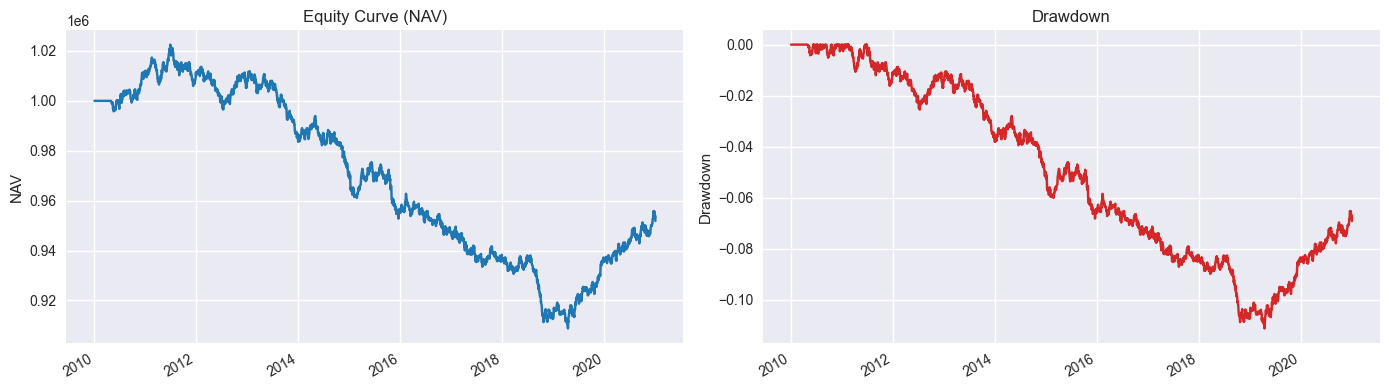

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

result.nav.plot(ax=axes[0], color="tab:blue", title="Equity Curve (NAV)")
axes[0].set_ylabel("NAV")

drawdown = result.nav / result.nav.cummax() - 1.0
drawdown.plot(ax=axes[1], color="tab:red", title="Drawdown")
axes[1].set_ylabel("Drawdown")

plt.tight_layout()

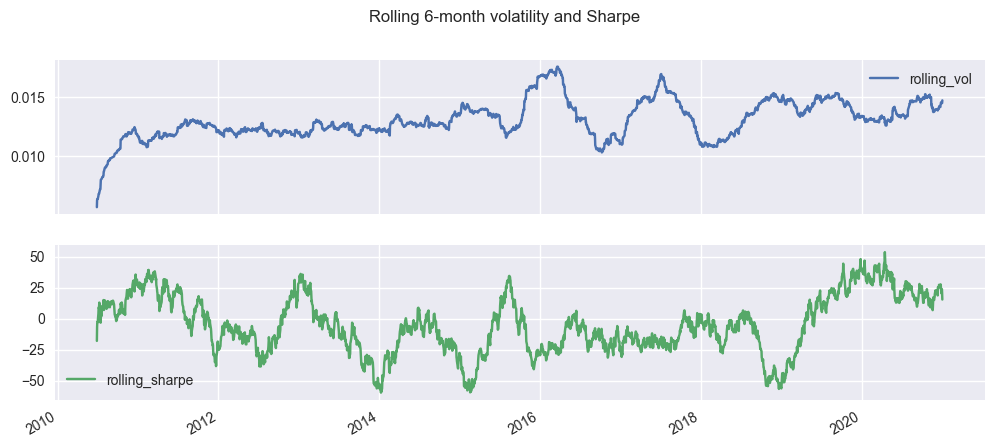

In [8]:
rolling = compute_rolling_metrics(result.nav, window=126)
if not rolling.empty:
    rolling.plot(subplots=True, figsize=(12, 5), title="Rolling 6-month volatility and Sharpe")
else:
    print("Not enough data for rolling metrics.")

## 4. Attribution, exposures, and diagnostics

The evaluation toolkit surfaces position exposures, instrument and sector PnL, and cost attribution. These tables feed the automated HTML/PDF reports shipped with the CLI.

In [9]:
from tf.eval.analytics import (
    compute_exposures,
    compute_pnl_contributions,
    compute_roll_cost_breakdown,
    compute_sector_contributions,
    normalise_totals,
)

exposure = compute_exposures(result.prices, result.positions, result.point_values)
instrument_pnl = compute_pnl_contributions(result.prices, result.positions, result.point_values)
sector_pnl = compute_sector_contributions(instrument_pnl, result.sector_map)
cost_breakdown = compute_roll_cost_breakdown(result.trades, result.costs)

top_exposure = exposure.abs().mean().sort_values(ascending=False).head(5)
display(pd.DataFrame({"avg_abs_notional": top_exposure}))

pnl_totals = normalise_totals(instrument_pnl.sum())
display(pd.DataFrame({"total_pnl": pnl_totals}))

if not sector_pnl.empty:
    sector_totals = normalise_totals(sector_pnl.sum())
    display(pd.DataFrame({"total_pnl": sector_totals}))

cost_breakdown

,avg_abs_notional
GC,35402.171286
NQ,34244.594265
ES,33699.175142
ZB,3052.878316
CL,2820.856882


,total_pnl
ZB,-22153.933353
NQ,20658.432127
CL,-13582.038811
ES,8307.689174
GC,1619.600631
ZN,0.000000
6E,0.000000
6J,0.000000


,total_pnl
Equities,28966.121301
Rates,-22153.933353
Commodities,-11962.438181
FX,0.000000


,amount
ledger_trading,43020.0
ledger_roll,0.0
ledger_total,43020.0
trades_rebalance,43020.0


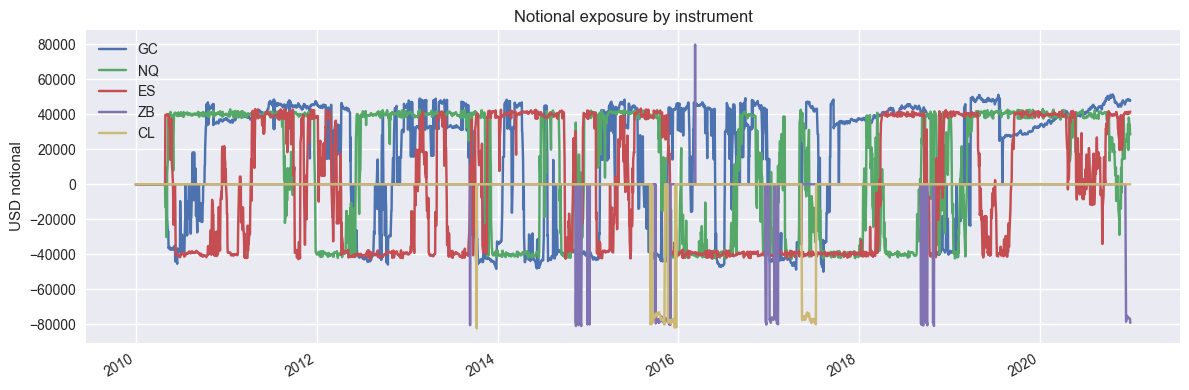

In [10]:
if not exposure.empty:
    cols = top_exposure.index
    exposure[cols].plot(figsize=(12, 4), title="Notional exposure by instrument")
    plt.ylabel("USD notional")
    plt.tight_layout()
else:
    print("Exposure dataframe is empty.")

### Trade log snapshot

Trades include slippage, commission, and reason codes (rebalance vs. roll) so that capacity and execution assumptions can be audited.

In [11]:
result.trades.head()

,ts,symbol,qty,price,notional,slippage,commission,cost,reason,order_id,partial,cash_after
0,2010-04-30,ES,8.0,99.241773,39696.709385,40.0,20.0,60.0,rebalance,1,False,960243.290615
1,2010-04-30,NQ,-7.0,93.181822,-13045.455140,35.0,17.5,52.5,rebalance,2,False,973236.245755
2,2010-05-03,GC,-1.0,93.718803,-9371.880343,5.0,2.5,7.5,rebalance,3,False,982600.626097
3,2010-05-04,NQ,-9.0,94.109710,-16939.747845,45.0,22.5,67.5,rebalance,4,False,999472.873943
4,2010-05-05,GC,1.0,93.902729,9390.272867,5.0,2.5,7.5,rebalance,5,False,990075.101076


## 5. Parameter sweeps for robustness

The :func:`tf.api.run_parameter_sweep` helper expands a grid of overrides and executes each scenario with reproducible seeds. Here we explore different momentum lookback mixes and volatility targets.

In [12]:
parameter_grid = {
    "signals.momentum.lookbacks": [
        [63, 126, 252],
        [63, 252],
        [126, 252],
    ],
    "risk.target_portfolio_vol": [0.12, 0.15, 0.18],
}

sweep_results, _ = api.run_parameter_sweep(
    CONFIG_PATH,
    parameter_grid=parameter_grid,
    price_seed=context.price_seed,
    check_reproducibility=False,
)

def flatten_mapping(mapping, prefix=""):
    items = {}
    for key, value in (mapping or {}).items():
        new_key = f"{prefix}.{key}" if prefix else str(key)
        if isinstance(value, dict):
            items.update(flatten_mapping(value, new_key))
        else:
            items[new_key] = value
    return items

records = []
for entry in sweep_results:
    overrides = flatten_mapping(entry.scenario.combined_overrides)
    metrics = performance_summary(
        entry.backtest.nav,
        pnl=entry.backtest.pnl,
        trades=entry.backtest.trades,
    )
    record = {**overrides, **metrics}
    record["config_hash"] = entry.backtest.config_hash
    records.append(record)

sweep_frame = pd.DataFrame(records)
sweep_frame.sort_values("Sharpe", ascending=False).reset_index(drop=True)

,signals.momentum.lookbacks,risk.target_portfolio_vol,CAGR,Volatility,Sharpe,Sortino,Max Drawdown,Calmar,Skew,Kurtosis,Turnover,Hit Rate,config_hash
0,"[63, 252]",0.18,-0.002903,0.013157,-0.214361,-0.205475,-0.104903,-0.027670,-0.098762,0.389310,35.247079,0.488323,141f2542e404f83280fd755d0d68a76f6c1588e6000e97...
1,"[63, 252]",0.12,-0.003174,0.012686,-0.244215,-0.234573,-0.104003,-0.030515,-0.094756,0.483998,34.317414,0.486581,19807707264ee8415387e4db5be76535db0bb9f527fe67...
2,"[63, 252]",0.15,-0.003477,0.013031,-0.260727,-0.249235,-0.108828,-0.031945,-0.102257,0.414772,34.495879,0.488672,71a9e7b2b6a8b347529e8603cfdf14346023ee1ed8a793...
3,"[63, 126, 252]",0.12,-0.004039,0.012708,-0.312150,-0.300710,-0.107434,-0.037599,-0.082049,0.487698,31.179479,0.482398,876cb2f04c629e701f5131edea53cd1d8d6685d9beea7f...
4,"[63, 126, 252]",0.15,-0.004327,0.013056,-0.325598,-0.313431,-0.111264,-0.038889,-0.082064,0.429291,30.959539,0.482049,36dc6c2e1df0d3965a0aa9e50336a3a968b8adda789ab8...
5,"[126, 252]",0.18,-0.004411,0.013173,-0.328996,-0.310649,-0.103613,-0.042569,-0.128464,0.452881,29.380726,0.474033,941268daa32981d91403686e9b7acb6b388ad9b5d17948...
6,"[126, 252]",0.15,-0.004342,0.012883,-0.331304,-0.313145,-0.103470,-0.041961,-0.117254,0.425434,29.095164,0.473684,94cbffdc7db5405fb4f94e7ea4eebe6d5cd4590f93f423...
7,"[63, 126, 252]",0.18,-0.004530,0.013305,-0.334593,-0.320418,-0.114615,-0.039524,-0.096573,0.449794,31.804705,0.484838,988659f0d2d040503b15072da890c27cba69bb21547c4e...
8,"[126, 252]",0.12,-0.004877,0.012564,-0.382841,-0.360108,-0.110020,-0.044329,-0.143171,0.491013,28.448651,0.474033,f923d2b7396b54c190c87206d1388670c8fcb48a3b5148...


## 6. Walk-forward evaluation

Walk-forward analysis mimics a research-to-production hand-off by retraining on historical windows and validating on held-out periods. The helper returns detailed metadata for each fold.

In [13]:
from tf.research.walkforward import generate_walk_forward_windows

wf_results, _ = api.run_walk_forward(
    CONFIG_PATH,
    insample=756,
    oos=252,
    step=252,
    anchored=True,
    price_seed=context.price_seed,
    check_reproducibility=False,
)

wf_records = []
for item in wf_results:
    oos_summary = item.oos_summary
    wf_records.append(
        {
            "insample_start": item.window.insample_start.date().isoformat(),
            "insample_end": item.window.insample_end.date().isoformat(),
            "oos_start": item.window.oos_start.date().isoformat(),
            "oos_end": item.window.oos_end.date().isoformat(),
            "oos_sharpe": oos_summary.get("Sharpe", float("nan")),
            "oos_cagr": oos_summary.get("CAGR", float("nan")),
            "oos_max_drawdown": oos_summary.get("Max Drawdown", float("nan")),
        }
    )

pd.DataFrame(wf_records)

,insample_start,insample_end,oos_start,oos_end,oos_sharpe,oos_cagr,oos_max_drawdown
0,2010-01-01,2012-11-23,2012-11-26,2013-11-12,-1.434688,-0.017857,-0.019222
1,2010-01-01,2013-11-12,2013-11-13,2014-10-30,-0.821755,-0.010346,-0.012026
2,2010-01-01,2014-10-30,2014-10-31,2015-10-19,-1.045042,-0.014611,-0.021775
3,2010-01-01,2015-10-19,2015-10-20,2016-10-05,-1.044151,-0.014466,-0.019359
4,2010-01-01,2016-10-05,2016-10-06,2017-09-22,-1.191906,-0.017328,-0.021579
5,2010-01-01,2017-09-22,2017-09-25,2018-09-11,-0.918013,-0.011661,-0.015863
6,2010-01-01,2018-09-11,2018-09-12,2019-08-29,-0.153840,-0.002365,-0.019343
7,2010-01-01,2019-08-29,2019-08-30,2020-08-17,1.518074,0.021252,-0.005197


## 7. Monte-Carlo confidence intervals

Block bootstrap resampling provides confidence intervals that respect serial correlation in daily returns. These bands contextualise the point estimates reported in the performance summary.

In [14]:
import dataclasses
from tf.research.monte_carlo import bootstrap_confidence_intervals

returns = result.nav.pct_change().dropna()
intervals = bootstrap_confidence_intervals(
    returns,
    metrics=["sharpe", "max_drawdown"],
    n_samples=1000,
    block_size=20,
    seed=42,
)

pd.DataFrame({name: dataclasses.asdict(interval) for name, interval in intervals.items()}).T

,mean,lower,upper
sharpe,-0.326990,-0.908477,0.228417
max_drawdown,-0.075285,-0.138708,-0.032210


## 8. Sensitivity analysis utilities

The research module exposes small helpers for probing how key metrics change across parameter sweeps without writing bespoke loops.

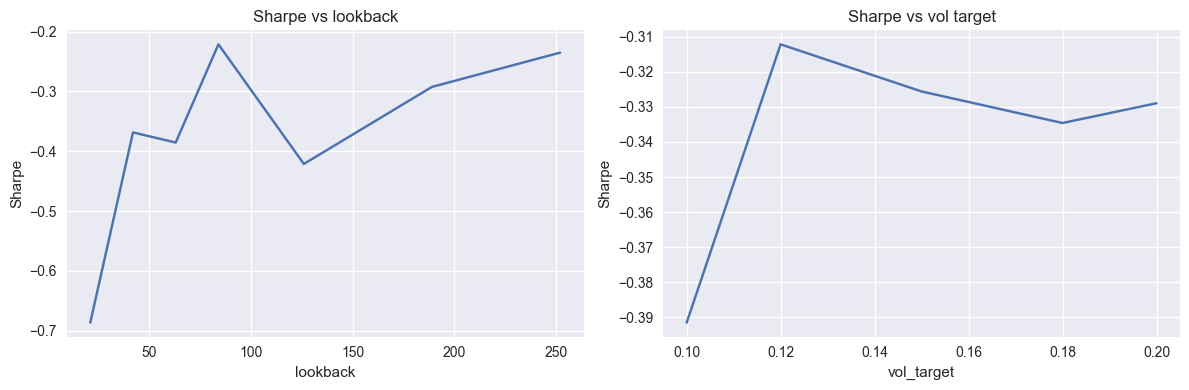

In [15]:
from tf.research import sensitivity

lookback_curve = sensitivity.lookback_sensitivity(
    backtester,
    lookbacks=[21, 42, 63, 84, 126, 189, 252],
)
vol_curve = sensitivity.vol_target_sensitivity(
    backtester,
    targets=[0.10, 0.12, 0.15, 0.18, 0.20],
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

lookback_curve.plot(ax=axes[0], legend=False, title="Sharpe vs lookback")
axes[0].set_ylabel("Sharpe")

vol_curve.plot(ax=axes[1], legend=False, title="Sharpe vs vol target")
axes[1].set_ylabel("Sharpe")

plt.tight_layout()

## 9. Wrap-up

All artefacts generated here mirror the deliverables from the command-line interface: NAV curves, trade logs, attribution tables, and experiment metadata are written under ``results/`` using deterministic configuration hashes. The notebook provides a convenient playground for extending the strategy, onboarding new markets, or benchmarking research ideas before promoting them into automated workflows.